In [15]:
from pathlib import Path
import numpy as np
import json

import shap

import sys
sys.path.insert(0, '..')

from predictor.models import nn_FeedForward
from predictor.preprocessing import VALUE_COLS, VEGETATION_LABELS
from predictor.analysis import plot_shap_values

In [2]:
path_to_arrays = Path('../data/processed/arrays')

In [3]:
with open('../data/processed/normalizing_dict.json', 'r') as f:
    normalizing_dict = json.load(f)

In [4]:
model = nn_FeedForward(path_to_arrays, hide_vegetation=True)

In [5]:
model.train(num_epochs=1)

Training model without vegetation features


  0%|          | 35/8175 [00:00<00:23, 346.74it/s]

After split, training on 261593 examples, validating on 29065 examples


100%|██████████| 909/909 [00:00<00:00, 1554.86it/s]

Epoch 0 - Training RMSE: 0.07155554849665828, Validation RMSE: 0.07006661071389815


In [6]:
model.evaluate()

100%|██████████| 916/916 [00:00<00:00, 1223.95it/s]

Test set RMSE: 0.08585281670093536


Load the tensors for the background and targets

In [7]:
background_data = model.load_tensors(mode='train')

Training model without vegetation features


In [8]:
test_data = model.load_tensors(mode='test')

Let's pick 100 instances of the data as the background

In [9]:
num_samples = 100
background_x = background_data.x[np.random.randint(0, background_data.x.shape[0], num_samples)]

Next, lets predict for the first two instances in `test_data`

In [10]:
test_x = test_data.x[:2]
test_true = test_data.y[:2]

In [11]:
e = shap.DeepExplainer(model.model, background_x)

In [12]:
shap_values = e.shap_values(test_x)

Next, let's denormalize the values so they are more meaningful to us.

In [13]:
values_no_veg = [val for val in VALUE_COLS if val not in VEGETATION_LABELS]

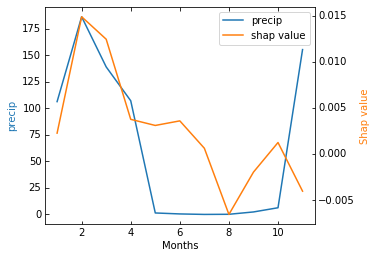

In [16]:
plot_shap_values(test_x[0], shap_values[0], values_no_veg, normalizing_dict, 'precip')